# Iteration 7: includes Audit class to record delays and calculate delay probabilities aslo it includes multiple repllicates run function of the model. Includes a warm up analysis and plotting. Also includes the 3 different scenarios.


---

## **Patient Admission Sources and Flows in the Acute Stroke Unit (ASU)**

Patients enter the hospital through various admission pathways and are assigned to the Acute Stroke Unit (ASU) based on their condition. This section provides a breakdown of admission sources, average time to admission, length of stay, and discharge destinations for different patient types.

---

### **1. Patient Admissions by Type**

| **Patient Type**                 | **Admissions (n)** | **Percentage (%)** |
|----------------------------------|--------------------|---------------------|
| Stroke                           | 1,320              | 54%                 |
| Transient Ischemic Attack (TIA)  | 158                | 6%                  |
| Complex Neurological             | 456                | 19%                 |
| Other Medical Cases              | 510                | 21%                 |

**Note:** *"New Admissions" refer to patients directly admitted to the hospital with the above conditions.*

---

### **2. Average Time to Admission**  

| **Patient Category**             | **Mean Time to Admission (Days)** |
|----------------------------------|-----------------------------------|
| Stroke                           | 1.2                               |
| TIA                              | 9.3                               |
| Complex Neurological             | 3.6                               |
| Other Medical Cases              | 3.2                               |

---

### **3. Acute Length of Stay (LoS)**  

Length of stay in the ASU follows a **lognormal distribution**. Descriptive statistics for each patient group are provided below:

| **Patient Group**      | **Mean** | **Stdev** | **Median** | **5th %ile** | **25th %ile** | **75th %ile** | **95th %ile** |
|------------------------|----------|-----------|------------|--------------|----------------|----------------|----------------|
| Stroke                 | 7.4      | 8.6       | 4.0        | 1.0          | 2.0            | 9.0            | 23.0           |
| TIA                    | 1.8      | 2.3       | 1.0        | 0.5          | 1.0            | 2.0            | 4.0            |
| Complex Neurological   | 4.0      | 5.0       | 2.0        | 0.5          | 1.0            | 5.0            | 13.6           |
| Other                  | 3.8      | 5.2       | 2.0        | 0.5          | 1.0            | 5.0            | 12.1           |

---

### **4. Patient Transfer Probabilities After Acute Phase**  

Following their acute stay, patients are transferred to Rehabilitation Units (RU), Extended Stay Discharge (ESD), or other destinations (e.g., home, care facilities, or mortality):

| **Destination** | **Stroke** | **TIA** | **Complex Neurological** | **Other** |
|-----------------|------------|---------|---------------------------|-----------|
| Rehabilitation  | 24%        | 1%      | 11%                       | 5%        |
| ESD             | 13%        | 1%      | 5%                        | 10%       |
| Other*          | 63%        | 98%     | 84%                       | 85%       |

*“Other” includes discharge to home, care homes, or death.*

---

### **5. Process Flow Diagram**

The following diagram illustrates the patient flow logic within the replicated ASU model:

![Iteration 1](images/replicated_model.png)

## 1. Imports 

In [1]:
from distribution import Exponential, Lognormal
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import itertools
import simpy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

sns.set()

## 2. Constants

In [2]:
# Model parameters

# RUN_LENGTH
WARM_UP_PERIOD = 365 * 3

DEFAULT_RESULTS_COLLECTION_PERIOD = 365 * 5

RUN_LENGTH = DEFAULT_RESULTS_COLLECTION_PERIOD + WARM_UP_PERIOD

# default number of repetitions
DEFAULT_N_REPS = 5

# default mean inter-arrival times(exp)
IAT_STROKE = 1.2
IAT_TIA = 9.3
IAT_COMPLEX_NEURO = 3.6
IAT_OTHER = 3.2

# Default Length of Stay (LOS) parameters
# (mean, stdev for Lognormal distribution
LOS_STROKE = (7.4, 8.6)
LOS_TIA = (1.8, 2.3)
LOS_COMPLEX_NEURO = (4.0, 5.0)
LOS_OTHER = (3.8, 5.2)
LOS_STROKE_NESD = (7.4, 8.6)
LOS_STROKE_ESD = (4.6, 4.8)
LOS_STROKE_MORTALITY = (7.0, 8.7)

# Acute Stroke Unit (ASU) bed capacity
ASU_BEDS = 10

# % where patients go after the Acute Stroke Unit (ASU)
TRANSFER_PROBABILITIES = {
    "stroke": {"rehab": 0.24, "esd": 0.13, "other": 0.63},
    "tia": {"rehab": 0.01, "esd": 0.01, "other": 0.98},
    "complex_neuro": {"rehab": 0.11, "esd": 0.05, "other": 0.84},
    "other": {"rehab": 0.05, "esd": 0.10, "other": 0.85},
}


# sampling settings, 4 for arrivals, 4 for LOS
# and for 4 transfer probabilities
N_STREAMS = 12
DEFAULT_RND_SET = 101

# Boolean switch to simulation results as the model runs
TRACE = False

## 3. Helper classes and functions

In [3]:
def trace(msg):
    """
    Turing printing of events on and off.

    Params:
    -------
    msg: str
        string to print to screen.
    """
    if TRACE:
        print(msg)

## 4. Audit Class

In [4]:
class Auditor:
    """
    Records and analyzes the performance
    metrics of the Acute Stroke Unit model.
    """

    def __init__(self):
        """
        Initializes the Auditor with empty lists for
        delay times and bed occupancy, plus a counter
        for the number of patients after warm-up.

        Attributes
        ----------
        delays : list
            Stores tuples of (patient_type, delay, timestamp).
        bed_occupancy : list
            Stores tuples of (occupancy, timestamp).
        n_patients : int
            Tracks number of patients after warm-up.
        """
        self.delays = []  # Stores (patient_type, delay, timestamp)
        self.bed_occupancy = []  # Stores (occupancy, timestamp)

    def record_delay(self, patient_type, delay, timestamp):
        """
        Records the delay information for a patient.

        Parameters
        ----------
        patient_type : str
            The type of patient (e.g., 'stroke', 'TIA').
        delay : float
            The delay time experienced by the patient.
        timestamp : float
            The simulation time at which the delay occurred.
        """
        self.delays.append((patient_type, delay, timestamp))

    def record_occupancy(self, occupancy, timestamp):
        """
        Records the bed occupancy at a given time.

        Parameters
        ----------
        occupancy : int
            The number of beds occupied.
        timestamp : float
            The simulation time at which the occupancy is recorded.
        """
        self.bed_occupancy.append((occupancy, timestamp))

    def count_patient_delays(self, warmup=0):
        """
        Return counts of total, delayed, and non-delayed patients
        after the given warm-up period.
        """
        # Convert the stored data into a DataFrame
        df = pd.DataFrame(
            self.delays, columns=["patient_type", "delay", "timestamp"]
        )

        # Filter out any data before warm-up
        df = df[df["timestamp"] >= warmup]

        if df.empty:
            return {"n_total": 0, "delayed": 0, "non_delayed": 0}
        else:
            # Count how many experienced a delay (delay > 0)
            delayed_patients = (df["delay"] > 0).sum()
            total_patients = len(df)
            nonlocal_non_delayed_patients = total_patients - delayed_patients

        return {
            "n_total": total_patients,
            "delayed": delayed_patients,
            "non_delayed": nonlocal_non_delayed_patients,
        }

    def compute_delay_prob(self, warmup=0):
        """
        Computes the delay probability after the warm-up period.
        Here, delay probability means the fraction of patients
        who experienced any delay (delay > 0).

        Parameters
        ----------
        warmup : int, optional
            The warm-up period duration to exclude from
            the analysis (default is 0).

        Returns
        -------
        dict
            A dictionary containing:
            - "overall": the fraction of patients delayed.
            - "by_type": a dictionary of delay fractions by patient type.
        """
        # Convert to a DataFrame
        df = pd.DataFrame(
            self.delays, columns=["patient_type", "delay", "timestamp"]
        )
        # Filter out data before warm-up
        df = df[df["timestamp"] >= warmup]
        if df.empty:
            return {"overall": 0.0, "by_type": {}}

        # Compute whether delay occurred (1 if delay > 0, else 0)
        df["is_delayed"] = df["delay"].apply(lambda x: 1 if x > 0 else 0)

        overall_delay_prob = df["is_delayed"].mean()
        by_type = df.groupby("patient_type")["is_delayed"].mean().to_dict()

        return {"overall": overall_delay_prob, "by_type": by_type}

    def compute_avg_delay(self, warmup=0):
        """
        Computes the average delay after the warm-up period.
        This differs from `compute_delay_prob` by actually
        reporting the mean delay time rather than a 0/1 fraction.

        Parameters
        ----------
        warmup : int, optional
            The warm-up period duration to exclude from
            the analysis (default is 0).

        Returns
        -------
        dict
            A dictionary containing:
            - "overall": the mean delay (in whatever time units used).
            - "by_type": a dictionary of mean delay by patient type.
        """
        # Convert to a DataFrame
        df = pd.DataFrame(
            self.delays, columns=["patient_type", "delay", "timestamp"]
        )
        # Filter out data before warm-up
        df = df[df["timestamp"] >= warmup]
        if df.empty:
            return {"overall": 0.0, "by_type": {}}

        overall_avg_delay = df["delay"].mean()
        by_type = df.groupby("patient_type")["delay"].mean().to_dict()

        return {"overall": overall_avg_delay, "by_type": by_type}

    def compute_bed_utilization(self, warmup=0):
        """
        Computes the average bed utilization after
        the warm-up period.

        Parameters
        ----------
        warmup : int, optional
            The warm-up period duration to exclude
            from the analysis (default is 0).

        Returns
        -------
        dict
            A dictionary containing:
            - "overall": the average occupancy over time.
        """
        df = pd.DataFrame(
            self.bed_occupancy, columns=["occupancy", "timestamp"]
        )
        df = df[df["timestamp"] >= warmup]

        if df.empty:
            return {"overall": 0.0}

        return {"overall": df["occupancy"].mean()}

## 5. Experiment class

In [5]:
class Experiment:
    """
    Encapsulates the concept of an experiment for the Acute Stroke Unit
    simulation.
    Manages parameters, PRNG streams, and results.
    """

    def __init__(
        self,
        auditor,
        random_number_set=DEFAULT_RND_SET,
        n_streams=N_STREAMS,
        iat_stroke=IAT_STROKE,
        iat_tia=IAT_TIA,
        iat_complex_neuro=IAT_COMPLEX_NEURO,
        iat_other=IAT_OTHER,
        asu_beds=ASU_BEDS,
        los_stroke=LOS_STROKE,
        los_tia=LOS_TIA,
        los_complex_neuro=LOS_COMPLEX_NEURO,
        los_other=LOS_OTHER,
        transfer_probabilities=TRANSFER_PROBABILITIES,
    ):
        """
        Initialize default parameters.
        """
        # Sampling settings
        self.random_number_set = random_number_set
        self.n_streams = n_streams

        # Model parameters
        self.iat_stroke = iat_stroke
        self.iat_tia = iat_tia
        self.iat_complex_neuro = iat_complex_neuro
        self.iat_other = iat_other
        self.asu_beds = asu_beds

        # LOS Parameters
        self.los_stroke = los_stroke
        self.los_tia = los_tia
        self.los_complex_neuro = los_complex_neuro
        self.los_other = los_other

        # Transfer probabilities
        self.transfer_probabilities = transfer_probabilities

        # Initialize results storage
        self.init_results_variables()

        # Initialize sampling distributions (RNGs)
        self.init_sampling()

        # Audit object
        self.auditor = auditor

    def set_random_no_set(self, random_number_set):
        """
        Controls the random sampling by re-seeding.
        """
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        """
        Creates the distributions used by the model and initializes
        the random seeds of each.
        """
        # Create a new seed sequence
        seed_sequence = np.random.SeedSequence(self.random_number_set)
        # Produce n non-overlapping streams
        self.seeds = seed_sequence.spawn(self.n_streams)

        # Prepare a list of RNGs
        rng_list = [np.random.default_rng(s.entropy) for s in self.seeds]

        # Inter-arrival time distributions
        self.arrival_stroke = Exponential(self.iat_stroke, self.seeds[0])
        self.arrival_tia = Exponential(self.iat_tia, self.seeds[1])
        self.arrival_complex_neuro = Exponential(
            self.iat_complex_neuro, self.seeds[2]
        )
        self.arrival_other = Exponential(self.iat_other, self.seeds[3])

        # LOS distributions using stored parameters
        self.los_distributions = {
            "stroke": Lognormal(
                self.los_stroke[0], self.los_stroke[1], self.seeds[4]
            ),
            "tia": Lognormal(self.los_tia[0], self.los_tia[1], self.seeds[5]),
            "complex_neuro": Lognormal(
                self.los_complex_neuro[0],
                self.los_complex_neuro[1],
                self.seeds[6],
            ),
            "other": Lognormal(
                self.los_other[0], self.los_other[1], self.seeds[7]
            ),
        }

        # RNGs specifically for transfer choices (1 per patient type)
        self.transfer_rngs = {
            "stroke": rng_list[8],
            "tia": rng_list[9],
            "complex_neuro": rng_list[10],
            "other": rng_list[11],
        }

    def init_results_variables(self):
        """
        Initializes all the experiment variables used in results collection.
        """
        self.results = {
            "n_stroke": 0,
            "n_tia": 0,
            "n_complex_neuro": 0,
            "n_other": 0,
            "n_patients": 0,
            "stroke_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "tia_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "complex_neuro_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "other_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "total_transfers": {"rehab": 0, "esd": 0, "other": 0},
        }

## 6. Patient Class

In [6]:
class Patient:
    """
    Represents a patient in the Acute Stroke Unit simulation.

    Attributes
    ----------
    patient_id : int
        Unique identifier for the patient.
    env : simpy.Environment
        The simulation environment.
    args : Experiment
        Experiment object containing simulation parameters and random streams.
    acute_stroke_unit : AcuteStrokeUnit
        Reference to the ASU resource (bed capacity, queue).
    patient_type : str
        Type of patient ('stroke', 'TIA', 'complex_neuro', 'other').
    waiting_time : float
        Time patient waits for a bed.
    """

    def __init__(self, patient_id, env, args, acute_stroke_unit, patient_type):
        self.patient_id = patient_id
        self.env = env
        self.args = args
        self.acute_stroke_unit = acute_stroke_unit
        self.patient_type = patient_type
        self.waiting_time = 0.0

    def treatment(self):
        """
        Simulates the patients treatment process:
        - Requests a bed (may wait if unavailable).
        - Records waiting time and occupancy.
        - Simulates length of stay (LOS).
        - Upon discharge, calls `transfer()` to determine next destination.

        Parameters
        ----------
        audit : Audit
            Audit object used to record metrics such as
            waiting time and bed occupancy.
        """
        arrival_time = self.env.now
        los_distribution = self.args.los_distributions[self.patient_type]

        # Arrival message
        trace(
            f"Patient {self.patient_id} ({self.patient_type.upper()})\
                arrives at {arrival_time:.2f}."
        )

        # Request bed from the ASU
        with self.acute_stroke_unit.beds.request() as request:
            yield request
            self.delay = self.env.now - arrival_time
            self.args.auditor.record_delay(
                self.patient_type, self.delay, self.env.now
            )
            los = los_distribution.sample()

            # Bed assigned message
            trace(
                f"Patient {self.patient_id} ({self.patient_type.upper()}) \
                gets a bed at {self.env.now:.2f}."
                f" (Waited {self.delay:.2f} days)"
            )

            if self.delay > 0:
                trace(
                    f"Patient {self.patient_id} \
                    ({self.patient_type.upper()})  had a delay.)"
                )

            # Simulate length of stay
            yield self.env.timeout(los)

            # Leaving message
            trace(
                f"Patient {self.patient_id} ({self.patient_type.upper()}) \
                leaves at {self.env.now:.2f}."
                f" (LOS {los:.2f} days)"
            )

        # Transfer the patient after discharge
        self.transfer()

    def transfer(self):
        """
        Determines the patient's next destination based on
        the transfer probabilities.
        Logs and updates the experiment's results.
        """
        # Access the RNG and probabilities for this patient type
        rng = self.args.transfer_rngs[self.patient_type]
        p_dict = self.args.transfer_probabilities[self.patient_type]
        destinations = list(p_dict.keys())
        probs = list(p_dict.values())

        # Random draw for the transfer destination
        destination = rng.choice(destinations, p=probs)
        trace(
            f"Patient {self.patient_id} ({self.patient_type.upper()}) \
            is transferred to {destination.upper()}."
        )

        # Update results
        self.args.results["total_transfers"][destination] += 1
        self.args.results[f"{self.patient_type}_transfer"][destination] += 1

## 7. Acute Stroke Unit Class

In [7]:
class AcuteStrokeUnit:
    """
    Models the Acute Stroke Unit (ASU) in the hospital.
    Manages bed resources and handles patient arrivals and admissions.

    Attributes
    ----------
    env : simpy.Environment
        The simulation environment.
    args : Experiment
        Experiment object containing model parameters and random streams.
    beds : simpy.Resource
        SimPy resource representing available ASU beds.
    """

    def __init__(self, env, args):
        self.env = env
        self.args = args
        self.beds = simpy.Resource(env, capacity=args.asu_beds)

    def patient_arrivals(self, patient_type, arrival_distribution):
        """
        Generator process that simulates patient arrivals of a specific type.
        For each arrival:
        - Waits based on inter-arrival time (Exponential distribution).
        - Creates a new Patient instance.
        - Starts the treatment process for the patient.
        - Records arrival statistics in Experiment results.

        Parameters
        ----------
        patient_type : str
            Type of patient ('stroke', 'TIA', 'complex_neuro', 'other').
        arrival_distribution : Exponential
            Distribution object for sampling inter-arrival times.
        audit : Audit
            Audit object for recording delays and occupancy.
        """
        for patient_count in itertools.count(start=1):
            inter_arrival_time = arrival_distribution.sample()
            yield self.env.timeout(inter_arrival_time)

            # Track patient count
            self.args.results[f"n_{patient_type}"] += 1
            self.args.results["n_patients"] += 1

            trace(f"{self.env.now:.2f}: {patient_type.upper()} arrival.")

            new_patient = Patient(
                patient_count, self.env, self.args, self, patient_type
            )
            self.env.process(new_patient.treatment())

    def track_occupancy(self):
        """
        Track and record bed occupancy daily.
        """
        while True:
            occ = self.beds.count / self.beds.capacity
            self.args.auditor.record_occupancy(occ, self.env.now)
            yield self.env.timeout(1)

## 8. Single run function

In [8]:
def single_run(experiment, rep=0, run_length=RUN_LENGTH, warm_up=0):
    """
    Perform a single run of the model and return the results.

    Parameters
    ----------
    experiment : Experiment
        The experiment/parameters to use with model
    rep : int
        The replication number (used to set random seeds).
    run_length : float
        The run length of the model in days (default = the constant set).
    """
    # 1. Reset results for each run
    experiment.init_results_variables()

    # 2. Set the random number set for this run
    experiment.set_random_no_set(rep)

    # 3. Create a fresh environment and an AcuteStrokeUnit
    env = simpy.Environment()
    asu = AcuteStrokeUnit(env, experiment)

    # 4. Create patient arrival processes for different types of patients
    env.process(asu.patient_arrivals("stroke", experiment.arrival_stroke))
    env.process(asu.patient_arrivals("tia", experiment.arrival_tia))
    env.process(
        asu.patient_arrivals("complex_neuro", experiment.arrival_complex_neuro)
    )
    env.process(asu.patient_arrivals("other", experiment.arrival_other))
    trace(f"Rep {rep}: Patient arrival processes started.")

    # track the bed occupancy daily
    env.process(asu.track_occupancy())

    # 5. Run the simulation
    env.run(until=run_length + warm_up)
    trace(f"Rep {rep}: Simulation run completed.")

    # 6. Trace summary of total patients
    total_patients = sum(
        experiment.results[key]
        for key in experiment.results
        if key.startswith("n_")
    )
    trace(f"Final summary for rep={rep}: {total_patients} total patients.")

    # 7. Return experiment.results
    return experiment.results

## 9. Multiple runs function

In [9]:
def multiple_replications(
    scenario,
    rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
    n_reps=DEFAULT_N_REPS,
    warmup=0,
):
    """
    Perform multiple replications of the model.

    Parameters
    ----------
    scenario : Scenario
        Contains parameters/configuration for the model.
    rc_period : float, optional
        The number of minutes to run the model (beyond warmup)
        to collect results. Default is DEFAULT_RESULTS_COLLECTION_PERIOD.
    n_reps : int, optional
        Number of independent replications to run.
        Default is DEFAULT_N_REPS.
    warmup : float, optional
        The initial transient period (in minutes). Results
        in this period are excluded. Default is 0.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the replication number (in index),
        number of patients, overall delay probability, and average
        bed utilization for each replication.
    """
    # Lists to store replication results
    n_patients = []
    delay_probabilities = []
    bed_utilisation = []
    reps_info = []

    for rep in range(n_reps):
        # Use the same scenario object here, but if you need an
        # independent copy of the scenario for each replication,
        # make sure scenario is cloneable, e.g., scenario.copy()

        exp_temp = scenario
        scenario.auditor = Auditor()  # new Auditor

        # Run the simulation for the specified period
        single_run(exp_temp, rep=rep, run_length=rc_period)

        # Collect metrics
        # number of patients who were admitted to the unit
        num_patients = exp_temp.auditor.count_patient_delays(warmup=warmup)
        delay_prob = exp_temp.auditor.compute_delay_prob(warmup=warmup)
        bed_util = exp_temp.auditor.compute_bed_utilization(warmup=warmup)

        # Append results
        n_patients.append(num_patients["n_total"])
        delay_probabilities.append(delay_prob["overall"])
        bed_utilisation.append(bed_util["overall"])
        reps_info.append(f"Rep{rep + 1} of {n_reps}")

    # Create and return a DataFrame of the results
    df = pd.DataFrame(
        {
            "Patients": n_patients,
            "Overall Delay Probability": delay_probabilities,
            "Bed Utilisation": bed_utilisation,
        },
        index=reps_info,
    )

    # Renaming the index so it’s clear (optional)
    df.index.name = "Replication"

    return df

## 10. Multiple runs function with different beds

In [10]:
def multiple_runs(
    scenario,
    beds_start,
    beds_end,
    n_reps=DEFAULT_N_REPS,
    warmup=WARM_UP_PERIOD,
):
    """
    Perform multiple runs of the simulation across a range of bed capacities.

    For each bed capacity (from beds_start to beds_end), runs the simulation
    'n_reps' times and calculates the average patient count, delay probability,
    and bed utilization.

    Parameters
    ----------
    scenario : Scenario
        A configured Scenario object or similar structure for the simulation.
    n_reps : int
        Number of replications for each bed capacity.
    beds_start : int
        Starting number of beds to simulate.
    beds_end : int
        Ending number of beds to simulate (inclusive).
    warmup : float
        Initial transient period (in minutes).
        Results in this period are excluded.

    Returns
    -------
    pandas.DataFrame
        A summary DataFrame containing:
            - Bed Capacity
            - Avg. Patients      (average number of patients processed)
            - Overall Bed Utilization
            - Overall Delay Probability
            - 1 in every n Patients  (reciprocal of delay probability)
    """

    def run_single_experiment(bed, rep_id):
        # Depending on your scenario class, you might need to clone
        # or re-instantiate
        # the scenario to avoid side-effects across replications.
        experiment = scenario
        scenario.auditor = Auditor()  # new Auditor
        experiment.asu_beds = bed

        # Run the simulation. The parameter 'rep=rep_id'
        # might be used as a seed

        single_run(experiment, rep=rep_id)

        # Collect metrics from the Auditor
        delay_p = experiment.auditor.compute_delay_prob(warmup=warmup)
        util = experiment.auditor.compute_bed_utilization(warmup=warmup)
        n_patients = experiment.auditor.count_patient_delays(warmup=warmup)

        return n_patients["n_total"], delay_p["overall"], util["overall"]

    summary_list = []

    for bed in range(beds_start, beds_end + 1):
        print(
            f"Running experiment with {bed}"
            f" beds and {n_reps} replications, end={beds_end}"
        )

        # Run experiments in parallel for the current bed capacity
        results = Parallel(n_jobs=-1)(
            delayed(run_single_experiment)(bed, rep_id)
            for rep_id in range(n_reps)
        )

        # Unpack the returned tuples
        rep_patient_counts, rep_delay_probs, rep_bed_utils = zip(*results)

        # Compute averages
        avg_patients = np.mean(rep_patient_counts)
        avg_delay_prob = np.mean(rep_delay_probs)
        avg_bed_util = np.mean(rep_bed_utils)

        summary_list.append(
            {
                "Bed Capacity": bed,
                "Avg. Patients": avg_patients,
                "Overall Bed Utilization": avg_bed_util,
                "Overall Delay Probability": avg_delay_prob,
                "1 in every n Patients": (
                    1 / avg_delay_prob if avg_delay_prob != 0 else float("inf")
                ),
            }
        )

    print("Finished running all experiments.")

    # Convert the summary list to a DataFrame
    summary_df = pd.DataFrame(summary_list)
    return summary_df

## 11. Warmup analayis function

In [11]:
def warmup_analysis(run_length=RUN_LENGTH, reps=5, interval=50):
    """
    Warm-up period analysis.

    Parameters
    ----------
    run_length : int
        Total run length of the simulation.
    reps : int
        Number of replications.
    interval : int
        Interval for warm-up period analysis.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the warm-up analysis results.
    """
    results = []

    for i in range(1, run_length, interval):
        auditor = Auditor()
        experiment = Experiment(auditor=auditor)
        multi_rep = multiple_replications(
            scenario=experiment, rc_period=i, n_reps=reps
        )

        delay_p = multi_rep["Overall Delay Probability"].mean()
        util = multi_rep["Bed Utilisation"].mean()

        results.append(
            {
                "Run Length": i,
                "reps": reps,
                "Delay Probability": delay_p,
                "Bed Utilisation": util,
            }
        )

    df = pd.DataFrame(results)
    return df

---

## 12. Single run test & initial data inspection 

In [12]:
TRACE = False
auditor = Auditor()
experiment = Experiment(auditor=auditor)
result = single_run(experiment)
delay_p = experiment.auditor.compute_delay_prob(warmup=0)
bed_utilisation = experiment.auditor.compute_bed_utilization(warmup=0)
# number of patients who were admitted to the unit
num_patients = experiment.auditor.count_patient_delays(warmup=0)

In [13]:
# number Patient arrivals and number number patient who are transferred.
result

{'n_stroke': 2440,
 'n_tia': 335,
 'n_complex_neuro': 794,
 'n_other': 922,
 'n_patients': 4491,
 'stroke_transfer': {'rehab': 594, 'esd': 314, 'other': 1524},
 'tia_transfer': {'rehab': 4, 'esd': 3, 'other': 326},
 'complex_neuro_transfer': {'rehab': 73, 'esd': 39, 'other': 682},
 'other_transfer': {'rehab': 40, 'esd': 77, 'other': 800},
 'total_transfers': {'rehab': 711, 'esd': 433, 'other': 3332}}

In [14]:
# this is record of all patients who have been admitted to the unit.
delay_records = experiment.auditor.delays
len(delay_records)

4486

In [15]:
# number of patients who are admitted to the stroke unit.
# number of patients who are are waited experience a delay in the stroke unit.

num_patients

{'n_total': 4486, 'delayed': np.int64(2779), 'non_delayed': np.int64(1707)}

In [16]:
# delay probability and bed utilization with warm up = 0
print(f'bed utilization: {bed_utilisation["overall"]}')
print(f'delay probability: {delay_p["overall"]}')
print(f'delay probability of each patient type: {delay_p["by_type"]}')

bed utilization: 0.8729452054794521
delay probability: 0.6194828354881855
delay probability of each patient type: {'complex_neuro': 0.6234256926952141, 'other': 0.6376496191512514, 'stroke': 0.603363412633306, 'tia': 0.6776119402985075}


In [17]:
TRACE = False
auditor = Auditor()
experiment = Experiment(auditor=auditor)
result = single_run(experiment)
delay_p = experiment.auditor.compute_delay_prob(warmup=WARM_UP_PERIOD)
bed_utilisation = experiment.auditor.compute_bed_utilization(
    warmup=WARM_UP_PERIOD
)
num_patients = experiment.auditor.count_patient_delays(warmup=WARM_UP_PERIOD)

In [18]:
result

{'n_stroke': 2440,
 'n_tia': 335,
 'n_complex_neuro': 794,
 'n_other': 922,
 'n_patients': 4491,
 'stroke_transfer': {'rehab': 594, 'esd': 314, 'other': 1524},
 'tia_transfer': {'rehab': 4, 'esd': 3, 'other': 326},
 'complex_neuro_transfer': {'rehab': 73, 'esd': 39, 'other': 682},
 'other_transfer': {'rehab': 40, 'esd': 77, 'other': 800},
 'total_transfers': {'rehab': 711, 'esd': 433, 'other': 3332}}

In [19]:
# number of patients who are admitted to the stroke unit.
# number of patients who are are waited experience a delay in the stroke unit.

num_patients

{'n_total': 2768, 'delayed': np.int64(1691), 'non_delayed': np.int64(1077)}

In [20]:
# delay probability and bed utilization with warm up = default warm up
print(f"Number of patients: {num_patients}")
print(f'bed utilization: {bed_utilisation["overall"]}')
print(f'delay probability: {delay_p["overall"]}')
print(f'delay probability of each patient type: {delay_p["by_type"]}')

Number of patients: {'n_total': 2768, 'delayed': np.int64(1691), 'non_delayed': np.int64(1077)}
bed utilization: 0.8694794520547945
delay probability: 0.6109104046242775
delay probability of each patient type: {'complex_neuro': 0.6101010101010101, 'other': 0.6231884057971014, 'stroke': 0.6, 'tia': 0.6574074074074074}


## 13. Test on patient type - Should only see TIA patients

In [21]:
M = 1_000_000
auditor = Auditor()
experiment = Experiment(
    auditor=auditor, iat_stroke=M, iat_complex_neuro=M, iat_other=M
)
results = single_run(experiment)
results

{'n_stroke': 0,
 'n_tia': 335,
 'n_complex_neuro': 0,
 'n_other': 0,
 'n_patients': 335,
 'stroke_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'tia_transfer': {'rehab': 4, 'esd': 3, 'other': 328},
 'complex_neuro_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'other_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'total_transfers': {'rehab': 4, 'esd': 3, 'other': 328}}

## 14. Run multiple replications warmup=0

In [22]:
# 5 replications(defualt N_replication) and warm up = 0
TRACE = False
auditor = Auditor()
experiment = Experiment(auditor=auditor)
results_df = multiple_replications(experiment)

In [23]:
results_df

,Patients,Overall Delay Probability,Bed Utilisation
Replication,,,
Rep1 of 5,2824,0.610127,0.868712
Rep2 of 5,2786,0.610194,0.878466
Rep3 of 5,2830,0.665371,0.888000
Rep4 of 5,2735,0.479342,0.828110
Rep5 of 5,2817,0.625488,0.878247


In [24]:
results_df.mean()

Patients                     2798.400000
Overall Delay Probability       0.598104
Bed Utilisation                 0.868307
dtype: float64

## 15. Plotting warm-up data to inspect best cutoff

In [25]:
# for warmup analysis we will run the model for 10 years and record the
# data in a dataframe  with mean of 5 replication and
run_length = 365 * 10
n_reps = 5
interval = 30
warmup_df = warmup_analysis(run_length=run_length, reps=5, interval=interval)

In [26]:
warmup_df

,Run Length,reps,Delay Probability,Bed Utilisation
0,1,5,0.000000,0.000000
1,31,5,0.119360,0.607742
2,61,5,0.241154,0.706557
3,91,5,0.305978,0.748132
4,121,5,0.431850,0.790744
...,...,...,...,...
117,3511,5,0.582913,0.866072
118,3541,5,0.584577,0.866461
119,3571,5,0.584697,0.866480
120,3601,5,0.586124,0.866743


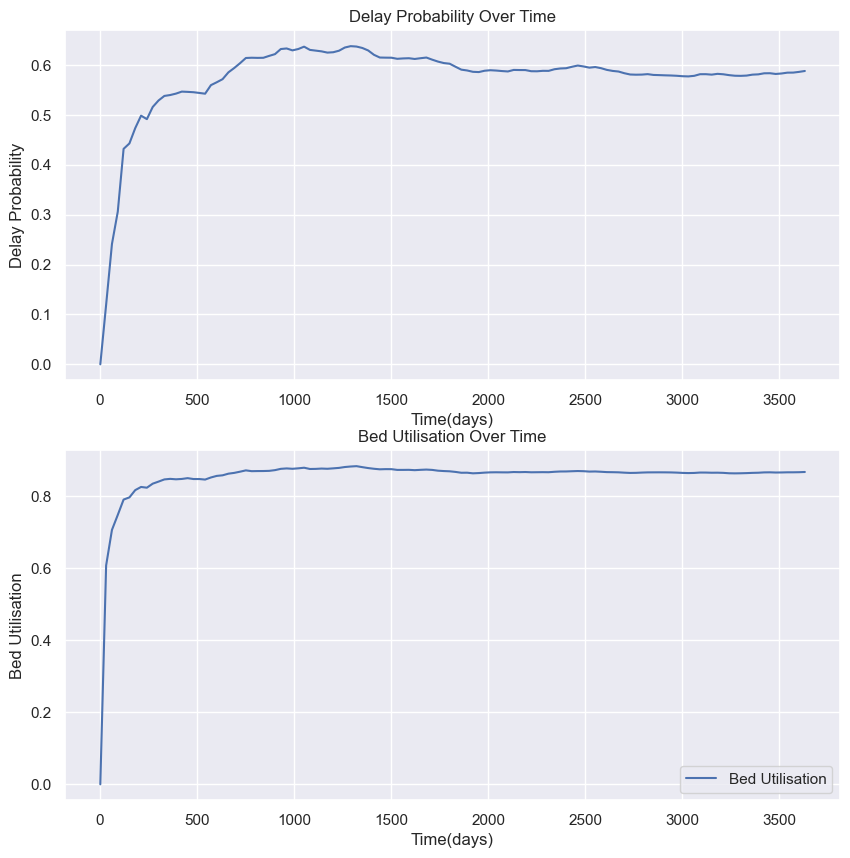

In [27]:
# plot warm up period
delay_p = warmup_df["Delay Probability"]
bed_utilisation = warmup_df["Bed Utilisation"]
time = warmup_df["Run Length"]
fix, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(time, delay_p, label="Delay Probability")
ax[0].set_xlabel("Time(days)")
ax[0].set_ylabel("Delay Probability")
ax[0].set_title("Delay Probability Over Time")
ax[1].plot(time, bed_utilisation, label="Bed Utilisation")
ax[1].set_xlabel("Time(days)")
ax[1].set_ylabel("Bed Utilisation")
ax[1].set_title("Bed Utilisation Over Time")
ax[1].legend()

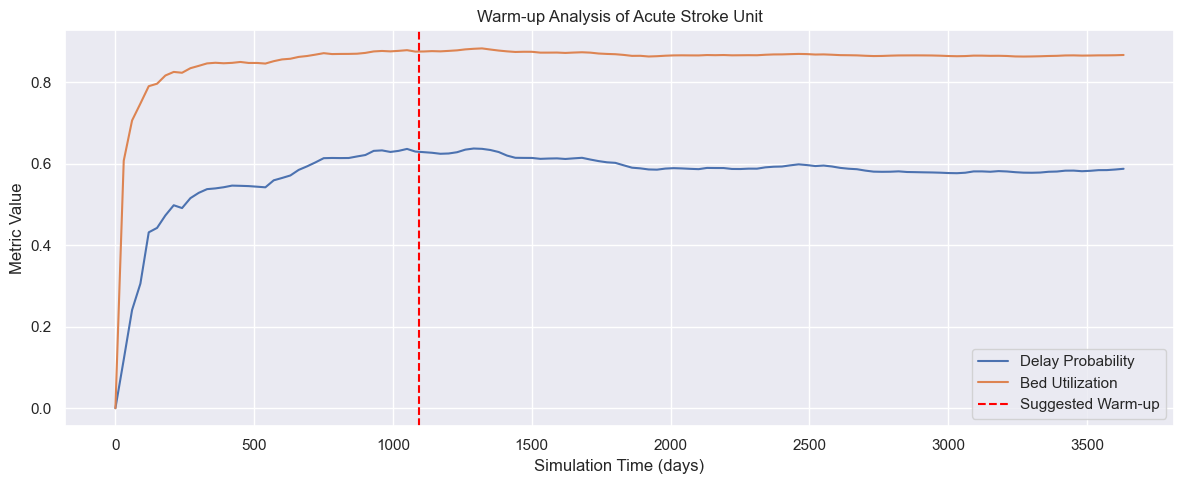

In [28]:
# plot warm up period
delay_p = warmup_df["Delay Probability"]
bed_utilisation = warmup_df["Bed Utilisation"]
time = warmup_df["Run Length"]

plt.figure(figsize=(12, 5))
plt.plot(time, delay_p, label="Delay Probability")
plt.plot(time, bed_utilisation, label="Bed Utilization")
plt.axvline(
    WARM_UP_PERIOD, color="red", linestyle="--", label="Suggested Warm-up"
)
plt.xlabel("Simulation Time (days)")
plt.ylabel("Metric Value")
plt.title("Warm-up Analysis of Acute Stroke Unit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 16.Selecting the number of replications to run.

In [29]:
def confidence_interval_method(
    replications,
    alpha=0.05,
    desired_precision=0.05,
    min_rep=5,
    decimal_place=2,
):
    """
    The confidence interval method for selecting the number of replications
    to run in a simulation.

    Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.

    Returns both the number of replications and the full results dataframe.

    Parameters:
    ----------
    replications: arraylike
        Array (e.g. np.ndarray or list) of replications of a performance metric

    alpha: float, optional (default=0.05)
        procedure constructs a 100(1-alpha) confidence interval for the
        cumulative mean.

    desired_precision: float, optional (default=0.05)
        Desired mean deviation from confidence interval.

    min_rep: int, optional (default=5)
        set to a integer > 0 and ignore all of the replications prior to it
        when selecting the number of replications to run to achieve the desired
        precision.  Useful when the number of replications returned does not
        provide a stable precision below target.

    decimal_places: int, optional (default=2)
        sets the number of decimal places of the returned dataframe containing
        the results

    Returns:
    --------
        tuple: int, pd.DataFrame

    """
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(
            cumulative_mean[i - 1]
            + (replications[i] - cumulative_mean[i - 1]) / (i + 1)
        )

        # running biased variance
        running_var.append(
            running_var[i - 1]
            + (replications[i] - cumulative_mean[i - 1])
            * (replications[i] - cumulative_mean[i])
        )

    # unbiased std dev = running_var / (n - 1)
    with np.errstate(divide="ignore", invalid="ignore"):
        running_std = np.sqrt(running_var / np.arange(n))

    # half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2), dof)
    with np.errstate(divide="ignore", invalid="ignore"):
        std_error = running_std / np.sqrt(np.arange(1, n + 1))

    half_width = t_value * std_error

    # upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width

    # Mean deviation
    with np.errstate(divide="ignore", invalid="ignore"):
        deviation = (half_width / cumulative_mean) * 100

    # commbine results into a single dataframe
    results = pd.DataFrame(
        [replications, cumulative_mean, running_std, lower, upper, deviation]
    ).T
    results.columns = [
        "Mean",
        "Cumulative Mean",
        "Standard Deviation",
        "Lower Interval",
        "Upper Interval",
        "% deviation",
    ]
    results.index = np.arange(1, n + 1)
    results.index.name = "replications"

    # get the smallest no. of reps
    # where deviation is less than precision target
    try:
        n_reps = (
            results.iloc[min_rep:]
            .loc[results["% deviation"] <= desired_precision * 100]
            .iloc[0]
            .name
        )
    except Exception as e:
        # no replications with desired precision
        message = "WARNING: the replications do not reach desired precision"
        if e:
            print(f"An n error occurred: {e}")
        else:
            print(message)
            n_reps = -1

    return n_reps, results.round(2)

In [30]:
# Firts let us run a a 150 replication of one scenario
auditor = Auditor()
experiment_default = Experiment(auditor=auditor)
results_default = multiple_replications(
    scenario=experiment_default, warmup=WARM_UP_PERIOD, n_reps=150
)

In [31]:
results_default.head()

,Patients,Overall Delay Probability,Bed Utilisation
Replication,,,
Rep1 of 150,1106,0.574141,0.853699
Rep2 of 150,1117,0.495076,0.843014
Rep3 of 150,1162,0.756454,0.926575
Rep4 of 150,1037,0.303761,0.775479
Rep5 of 150,1165,0.616309,0.893425


In [32]:
# run the method on the delay probability replications
n_reps, conf_ints = confidence_interval_method(
    results_default["Overall Delay Probability"].to_numpy(),
    desired_precision=0.05,
)

# print out the min number of replications to achieve precision
print(f"\nminimum number of reps for 5% precision: {n_reps}\n")

# peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: 50



,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,0.57,0.57,NaN,NaN,NaN,NaN
2,0.50,0.53,0.06,0.46,0.61,14.61
3,0.76,0.61,0.13,0.46,0.76,25.13
4,0.30,0.53,0.19,0.35,0.72,34.82
5,0.62,0.55,0.17,0.40,0.70,26.84


In [33]:
# run the method on the delay probability replications
n_reps, conf_ints = confidence_interval_method(
    results_default["Bed Utilisation"].to_numpy(), desired_precision=0.05
)

# print out the min number of replications to achieve precision
print(f"\nminimum number of reps for 5% precision: {n_reps}\n")

# peek at table of results
conf_ints.head()


minimum number of reps for 5% precision: 7



,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,0.85,0.85,NaN,NaN,NaN,NaN
2,0.84,0.85,0.01,0.84,0.86,1.24
3,0.93,0.87,0.05,0.82,0.93,5.93
4,0.78,0.85,0.06,0.79,0.91,7.19
5,0.89,0.86,0.06,0.81,0.91,5.87


---

# RESULTS

### Scenario 1: Current admissions level

In [34]:
# Scenario 1: Current Admissions
auditor = Auditor()
experiment_default = Experiment(auditor=auditor)
results_default = multiple_runs(
    scenario=experiment_default,
    beds_start=9,
    beds_end=17,
    warmup=WARM_UP_PERIOD,
    n_reps=150,
)
results_default["Scenario"] = "Current Admissions"

Running experiment with 9 beds and 150 replications, end=17
Running experiment with 10 beds and 150 replications, end=17
Running experiment with 11 beds and 150 replications, end=17
Running experiment with 12 beds and 150 replications, end=17
Running experiment with 13 beds and 150 replications, end=17
Running experiment with 14 beds and 150 replications, end=17
Running experiment with 15 beds and 150 replications, end=17
Running experiment with 16 beds and 150 replications, end=17
Running experiment with 17 beds and 150 replications, end=17
Finished running all experiments.


In [35]:
results_default["Overall Delay Probability"] = results_default[
    "Overall Delay Probability"
].round(2)
results_default["Overall Bed Utilization"] = results_default[
    "Overall Bed Utilization"
].round(2)
results_default["1 in every n Patients"] = results_default[
    "1 in every n Patients"
].round(0)

In [36]:
results_default

,Bed Capacity,Avg. Patients,Overall Bed Utilization,Overall Delay Probability,1 in every n Patients,Scenario
0,9,2785.626667,0.96,0.86,1.0,Current Admissions
1,10,2788.220000,0.86,0.57,2.0,Current Admissions
2,11,2788.580000,0.79,0.36,3.0,Current Admissions
3,12,2788.953333,0.72,0.22,5.0,Current Admissions
4,13,2789.013333,0.66,0.13,8.0,Current Admissions
5,14,2789.026667,0.62,0.07,14.0,Current Admissions
6,15,2788.986667,0.58,0.04,27.0,Current Admissions
7,16,2788.953333,0.54,0.02,55.0,Current Admissions
8,17,2788.940000,0.51,0.01,114.0,Current Admissions


In [37]:
results_default.to_csv("results/default_scenario.csv")

### Scenario 2: 5 % more admissions - A 5 % increase in admissions across all patient subgroups.

In [38]:
# Scenario 2: 5% Increase in Admissions
auditor = Auditor()
experiment_increase = Experiment(
    auditor=auditor,
    iat_stroke=IAT_STROKE * 0.95,
    iat_tia=IAT_TIA * 0.95,
    iat_complex_neuro=IAT_COMPLEX_NEURO * 0.95,
    iat_other=IAT_OTHER * 0.95,
)
results_increase = multiple_runs(
    scenario=experiment_increase,
    n_reps=150,
    beds_start=9,
    beds_end=17,
    warmup=WARM_UP_PERIOD,
)

results_increase["Scenario"] = "5% Increase in Admissions"

Running experiment with 9 beds and 150 replications, end=17
Running experiment with 10 beds and 150 replications, end=17
Running experiment with 11 beds and 150 replications, end=17
Running experiment with 12 beds and 150 replications, end=17
Running experiment with 13 beds and 150 replications, end=17
Running experiment with 14 beds and 150 replications, end=17
Running experiment with 15 beds and 150 replications, end=17
Running experiment with 16 beds and 150 replications, end=17
Running experiment with 17 beds and 150 replications, end=17
Finished running all experiments.


In [39]:
results_increase["Overall Delay Probability"] = results_increase[
    "Overall Delay Probability"
].round(2)
results_increase["Overall Bed Utilization"] = results_increase[
    "Overall Bed Utilization"
].round(2)
results_increase["1 in every n Patients"] = results_increase[
    "1 in every n Patients"
].round(0)

In [40]:
results_increase

,Bed Capacity,Avg. Patients,Overall Bed Utilization,Overall Delay Probability,1 in every n Patients,Scenario
0,9,2887.986667,0.99,0.98,1.0,5% Increase in Admissions
1,10,2934.366667,0.91,0.70,1.0,5% Increase in Admissions
2,11,2935.906667,0.83,0.46,2.0,5% Increase in Admissions
3,12,2935.920000,0.76,0.28,4.0,5% Increase in Admissions
4,13,2935.893333,0.70,0.17,6.0,5% Increase in Admissions
5,14,2935.833333,0.65,0.10,10.0,5% Increase in Admissions
6,15,2935.866667,0.61,0.05,19.0,5% Increase in Admissions
7,16,2935.866667,0.57,0.03,36.0,5% Increase in Admissions
8,17,2935.826667,0.54,0.01,72.0,5% Increase in Admissions


In [41]:
results_increase.to_csv("results/increase_scenario.csv")

### Scenario 3: No complex-neurological cases - Complex neurological patients are excluded from the pathway in order to assess their impact on bed requirements

In [42]:
# Scenario 4: Exclusion of Complex-Neurological Cases
auditor = Auditor()
experiment_exclusion = Experiment(
    auditor=auditor,
    iat_complex_neuro=float("inf"),  # Effectively excludes these patients
)
results_exclusion = multiple_runs(
    scenario=experiment_exclusion,
    n_reps=150,
    beds_start=9,
    beds_end=17,
    warmup=WARM_UP_PERIOD,
)

results_exclusion["Scenario"] = "No Complex-Neurological Cases"

Running experiment with 9 beds and 150 replications, end=17
Running experiment with 10 beds and 150 replications, end=17
Running experiment with 11 beds and 150 replications, end=17
Running experiment with 12 beds and 150 replications, end=17
Running experiment with 13 beds and 150 replications, end=17
Running experiment with 14 beds and 150 replications, end=17
Running experiment with 15 beds and 150 replications, end=17
Running experiment with 16 beds and 150 replications, end=17
Running experiment with 17 beds and 150 replications, end=17
Finished running all experiments.


In [43]:
results_exclusion

,Bed Capacity,Avg. Patients,Overall Bed Utilization,Overall Delay Probability,1 in every n Patients,Scenario
0,9,2285.333333,0.837790,0.525414,1.903261,No Complex-Neurological Cases
1,10,2285.806667,0.754179,0.319008,3.134717,No Complex-Neurological Cases
2,11,2286.180000,0.685717,0.185979,5.376954,No Complex-Neurological Cases
3,12,2286.260000,0.628614,0.103469,9.664772,No Complex-Neurological Cases
4,13,2286.300000,0.580266,0.053759,18.601673,No Complex-Neurological Cases
5,14,2286.273333,0.538841,0.026101,38.312813,No Complex-Neurological Cases
6,15,2286.260000,0.502931,0.012043,83.037898,No Complex-Neurological Cases
7,16,2286.246667,0.471489,0.005271,189.707903,No Complex-Neurological Cases
8,17,2286.246667,0.443760,0.002211,452.234618,No Complex-Neurological Cases


In [44]:
results_exclusion["Overall Delay Probability"] = results_exclusion[
    "Overall Delay Probability"
].round(2)
results_exclusion["Overall Bed Utilization"] = results_exclusion[
    "Overall Bed Utilization"
].round(2)
results_exclusion["1 in every n Patients"] = results_exclusion[
    "1 in every n Patients"
].round(0)

In [45]:
results_exclusion

,Bed Capacity,Avg. Patients,Overall Bed Utilization,Overall Delay Probability,1 in every n Patients,Scenario
0,9,2285.333333,0.84,0.53,2.0,No Complex-Neurological Cases
1,10,2285.806667,0.75,0.32,3.0,No Complex-Neurological Cases
2,11,2286.180000,0.69,0.19,5.0,No Complex-Neurological Cases
3,12,2286.260000,0.63,0.10,10.0,No Complex-Neurological Cases
4,13,2286.300000,0.58,0.05,19.0,No Complex-Neurological Cases
5,14,2286.273333,0.54,0.03,38.0,No Complex-Neurological Cases
6,15,2286.260000,0.50,0.01,83.0,No Complex-Neurological Cases
7,16,2286.246667,0.47,0.01,190.0,No Complex-Neurological Cases
8,17,2286.246667,0.44,0.00,452.0,No Complex-Neurological Cases


In [46]:
results_exclusion.to_csv("results/exclusion_sceranio.csv")

---

### Combined Results for 3 'what-if' scenarios

In [47]:
# Consolidate results
combined_results = pd.concat(
    [results_default, results_increase, results_exclusion], ignore_index=True
)

# Reorder columns for clarity
combined_results = combined_results[
    [
        "Scenario",
        "Bed Capacity",
        "Overall Bed Utilization",
        "Overall Delay Probability",
        "1 in every n Patients",
    ]
]

# Display the consolidated results
print(combined_results)

                         Scenario  Bed Capacity  Overall Bed Utilization  \
0              Current Admissions             9                     0.96   
1              Current Admissions            10                     0.86   
2              Current Admissions            11                     0.79   
3              Current Admissions            12                     0.72   
4              Current Admissions            13                     0.66   
5              Current Admissions            14                     0.62   
6              Current Admissions            15                     0.58   
7              Current Admissions            16                     0.54   
8              Current Admissions            17                     0.51   
9       5% Increase in Admissions             9                     0.99   
10      5% Increase in Admissions            10                     0.91   
11      5% Increase in Admissions            11                     0.83   
12      5% I

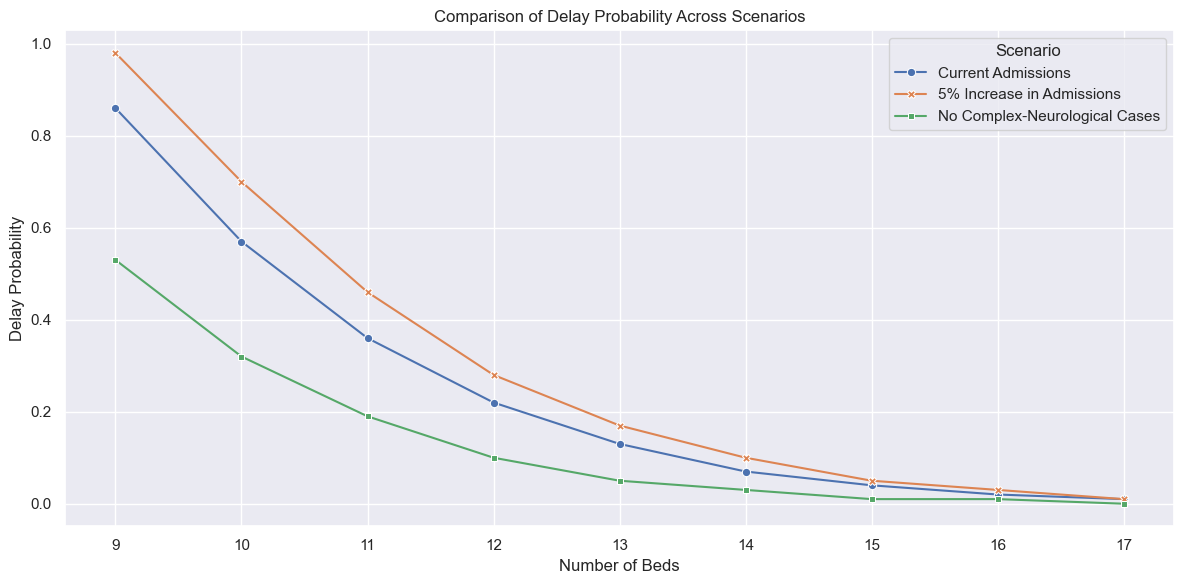

In [48]:
# Bed Capacity vs. Delay Probability
# Plot all scenarios using seaborn from the combined_results DataFrame
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_results,
    x="Bed Capacity",
    y="Overall Delay Probability",
    hue="Scenario",
    style="Scenario",
    markers=True,
    dashes=False,
)
plt.grid(True)
plt.xlabel("Number of Beds")
plt.ylabel("Delay Probability")
plt.title("Comparison of Delay Probability Across Scenarios")
plt.legend(title="Scenario")
plt.grid(True)
plt.savefig("results/comparing_delay_probability.png")
plt.tight_layout()
plt.show()